<p align="center">
    <img src="NFL_Banner.jpg" width=100%>
</p>

# NFL-Dataset

### NFL Scorigamis – Einzigartige Endstände im American Football
Ein Scorigami in der NFL bezeichnet ein Endergebnis, das in der Geschichte der Liga noch nie vorgekommen ist. Da es in American Football aufgrund der speziellen Punktevergabe (Touchdowns = 6 Punkte, Field Goals = 3 Punkte, Safeties = 2 Punkte, Extrapunkte & Two-Point Conversions) viele mögliche Endstände gibt, entstehen gelegentlich neue, zuvor unerreichte Kombinationen.

Die Spielregeln beeinflussen Scorigamis erheblich, da die unterschiedlichen Punktwerte und mögliche Kombinationen aus Touchdowns, Field Goals und Safeties zu teilweise ungewöhnlichen Ergebnissen führen können. Besonders seltene Ereignisse wie Safeties oder verfehlte Extrapunkte tragen oft dazu bei, neue Scorigamis zu ermöglichen.

Das Konzept wurde von Jon Bois populär gemacht, und es gibt mittlerweile eine Community, die jedes Spiel verfolgt, um zu sehen, ob ein neues Scorigami erzielt wurde.

### Schritt 1: Benötigte Libraries importieren

In [4]:
# Benötigte Libraries

# Webscraping
import csv
import requests
from bs4 import BeautifulSoup
from bs4 import Comment
from time import sleep
from tqdm import tqdm

# Visualisieren
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px

### Schritt 2: Web-Scraping
Es wird nun der Datensatz benötigt, der alle Spiele der NFL jemals beinhaltet. Dazu bietet sich die Website [pro-football-reference.com](https://www.pro-football-reference.com/boxscores/game-scores.htm) an. Sie beinhaltet zunächst alle Endstände sowie ihre Häufigkeit. Mittels `requests` wird die .html-Datei der Seite zunächst heruntergeladen und im Verzeichnis `data/` als `scores.html` gespeichert.

In [1]:
# Datei herunterladen

# URL, die gescraped werden soll
url = "https://www.pro-football-reference.com/boxscores/game-scores.htm"

# Erstelle GET-Request der URL
response = requests.get(url)

# Prüfe, ob Request erfolgreich war
if response.status_code == 200:
    # Speichere Seite in einer HTML-Datei
    with open("data/scores.html", "w", encoding="utf-8") as file:
        file.write(response.text)
    print("Page saved as 'scores.html'")
else:
    print(f"Failed to download page. Status code: {response.status_code}")

Page saved as 'scores.html'


Aus `scores.html` werden nun alle einzelnen Endstände mithilfe von `BeautifulSoup` geparsed und in der Variable `score_list` gespeichert. Basierend auf dieser Liste kann nun auf der o. g. Website auf die Spiele mit jeweiligem Endergebnis zugegriffen werden. Diese Subseiten werden mit dem Namen des Endergebnisses als .html-Datei im Verzeichnis `data/games/` gespeichert. Insgesamt entstehen dabei 1091 .html-Dateien.

In [74]:
# Datei nach Scores Parsen

# If the HTML is saved locally, you can use:
with open("data/scores.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

# Initialize an empty dictionary to store the country data
score_list = []

# Find all div elements with class "col-md-4 country"
for scores in soup.select("table.stats_table tbody tr:not([thead])"):
    score = scores.find("td").text
    score_list.append(score)

# Alle Spiele zu jedem Score finden

for score in tqdm(score_list,desc="Scores herunterladen"):
    i, j = score.split("-")
    url = f"https://www.pro-football-reference.com/boxscores/game_scores_find.cgi?pts_win={i}&pts_lose={j}"

    # Erstelle GET-Request der URL
    response = requests.get(url)

    # Prüfe, ob Request erfolgreich war
    if response.status_code == 200:
        # Speichere Seite in einer HTML-Datei
        with open(f"data/games/{i}-{j}.html", "w", encoding="utf-8") as file:
            file.write(response.text)
    else:
        print(f"Failed to download {i}-{j}.html. Status code: {response.status_code}")

    sleep(.75)

Scores herunterladen: 100%|██████████| 1091/1091 [53:59<00:00,  2.97s/it] 


Jetzt, wo die 1091 .html-Dateien lokal gespeichert sind, können auch sie mit BeautifulSoup geparsed werden. Dabei werden zunächst alle columns übernommen und später bereinigt. Die geparseden Ergebnisse werden in der Variable `games_list` gespeichert, die daraufhin in die Datei `data/games.csv` geschrieben werden. Diese Datei enthält nun alle Spiele der NFL samt Ergebnissen, Team-Namen, Spieltagen und vielen weiteren Statistiken (unbereinigt).

In [145]:
# Alle Spiele
games_list = []

# Alle Spiele in Dateien speichern
for score in tqdm(score_list,desc="Scores kombinieren"):
    i, j = score.split("-")

    # Datei nach jeweiligem Score speichern
    with open(f"data/games/{i}-{j}.html", "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "html.parser")

    # Alle Spiele des jeweiligen Scores
    for games in soup.select("table.stats_table tbody tr:not([thead])"):
        game = games.find_all("td")
        games_list.append([i.text.strip() for i in game])

# In CSV games.csv speichern
with open("data/games.csv", "a", newline="") as file:
    writer = csv.writer(file)
    fields = ["week", "day", "date", "outcome", "winner", "game_location", "loser", "boxscore", "pts_w", "pts_l", "yards_w", "to_w", "yards_l", "to_l"]

    writer.writerow(fields)
    writer.writerows(games_list)

print("Done!")

Scores kombinieren: 100%|██████████| 1091/1091 [04:20<00:00,  4.19it/s]

Done!


### Schritt 3: Datenbereinigung
Schaut man sich die `games.csv` an, fällt neben anderen Unreinheiten, die gesäubert werden sollten, auf, dass oft Team-Variationen als Namen vorkommen. So spielen bspw. 1944 die *Cleveland Rams*, 1962 aber die *Los Angeles Rams*. Wer sich mit der Historie der NFL und ihrer Teams auskennt, weiß, dass in beiden Fällen de facto das gleiche Team nur unter anderem Namen auftritt. In der Tat ist es so, dass viele NFL-Teams bereits (mehrmals) ihre Namen geändert haben.  
Diese Tatsache stellt aus der Perspektive der Datenverarbeitung in der Tat ein Problem dar. Möchte man z. B. die Anzahl der verschiedenen Teams, die in der NFL gespielt haben, zählen, würde eine verfälschte Zahl entstehen, wenn man einfach nur die Anzahl der einzigartigen Team-Namen berechnet. Es ist daher nötig, den Teams einzigartige IDs zuzuweisen, um sie definitiv voneinander unterscheiden zu können. Dadurch ist egal, wie das Team zu einem gegebenen Zeitpunkt geheißen hat, da es trotzdem noch das gleiche Team (also die gleiche ID) ist. Dadurch entsteht ein ER-Modell, was im Folgenden aufgezeigt ist.  
Auch hierbei soll uns wieder eine Seite von [pro-football-reference.com](https://www.pro-football-reference.com/teams/), die alle Teams und ihre früheren Namen auflistet, helfen.  
  
<p align="center">
    <img src="Database-Viz.png" width="1000">
</p>

Zunächst wird die Seite mit den Team-Daten heruntergeladen

In [109]:
# Datei herunterladen

# URL, die gescraped werden soll
url = "https://www.pro-football-reference.com/teams/index.htm"

# Erstelle GET-Request der URL
response = requests.get(url)

# Prüfe, ob Request erfolgreich war
if response.status_code == 200:
    # Speichere Seite in einer HTML-Datei
    with open("data/teams.html", "w", encoding="utf-8") as file:
        file.write(response.text)
    print("Page saved as 'teams.html'")
else:
    print(f"Failed to download page. Status code: {response.status_code}")

Page saved as 'teams.html'


Nun muss die heruntergeladenen Seite `teams.html` geparsed werden, um alle Team-Namen zu finden. Dabei muss zwischen Team-Namen und Varianten unterschieden werden. Glücklicherweise sind diese im Quellcode durch unterschiedliche `css`-Klassen voneinander trennbar und können somit unterschieden werden.

In [94]:
# Datei nach Scores Parsen

with open("data/teams.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

all_names = dict()
all_teams = []

cntr = 0

for team in soup.select("table.stats_table#teams_active tbody tr:not([thead])"):
    name = team.find("th").text.strip("*")
    year_min = team.find("td", {"data-stat": "year_min"}).text.strip()
    year_max = team.find("td", {"data-stat": "year_max"}).text.strip()
    if not len(team.attrs.values()):
        cntr +=1
    all_teams.append([cntr,int(not len(team.attrs.values())),name,year_min,year_max])

    

comments = soup.find_all(string=lambda text: isinstance(text, Comment))
soup = BeautifulSoup(comments[22], "html.parser")

for team in soup.select("table.stats_table#teams_inactive tbody tr:not([thead])"):
    name = team.find("th").text.strip("*")
    year_min = team.find("td", {"data-stat": "year_min"}).text.strip()
    year_max = team.find("td", {"data-stat": "year_max"}).text.strip()
    if not len(team.attrs.values()):
        cntr +=1
    all_teams.append([cntr,int(not len(team.attrs.values())),name,year_min,year_max])

all_teams = pd.DataFrame(all_teams,columns=["team_id", "is_latest_name","team_name", "first_year", "last_year"])
all_teams.drop_duplicates(inplace=True, ignore_index=True)
all_teams.to_csv("data/teams.csv",index=False)

print("Done!")

Done!


Im nächsten Schritt sollen den Teams in `games.csv` nun tatsächlich ihre generierten IDs zugewiesen werden. Dabei werden auch noch weitere Kleinigkeiten gesäubert.

In [199]:
games_df = pd.read_csv("data/games.csv")
teams_df = pd.read_csv("data/teams.csv")

games_new = []

games_df = games_df.drop("boxscore",axis=1)
games_df["game_location"] = games_df["game_location"].fillna(" ")

def find_team_id(source: pd.DataFrame, team: str, year: int):
    try:
        possible_teams = source[(source["team_name"] == team)]
        possible_teams = possible_teams[(year >= possible_teams["first_year"]) & (year <= possible_teams["last_year"] + 1)] # Die year-Spalten zeigen nur das erste Jahr der Saison.
        return int(possible_teams["team_id"].iloc[0])
    # Es gibt in der 1920 Saison Teams, die in der teams.csv nicht aufgelistet sind. Diese werden hier mit np.nan ersetzt, um die Endstände der Spiele trotzdem beizubehalten. 
    except IndexError:
        return np.nan

for index,game in tqdm(enumerate(games_df.values,1),desc=f"Applying Team-IDs to games"):
    # try:
    game = ([index] +
            list(game[:4]) +
            [find_team_id(teams_df, game[4], int(game[2][:4]))] +
            list(game[5]) +
            [find_team_id(teams_df, game[6], int(game[2][:4]))] +
            list(game[7:]))
    games_new.append(game)

games_df = pd.DataFrame(games_new,
                        columns=["game_id","week","day","date","outcome","winner_id","game_location","loser_id","pts_w","pts_l","yards_w","to_w","yards_l","to_l"]
                        ).convert_dtypes(convert_integer=True)

games_df["yards_w"] = games_df["yards_w"].replace(0,np.nan)
games_df["yards_l"] = games_df["yards_l"].replace(0,np.nan)
games_df.loc[games_df["date"] <= "1932-12-18", "to_w"] = np.nan
games_df.loc[games_df["date"] <= "1932-12-18", "to_l"] = np.nan

games_df.to_csv("data/games_cleaned.csv",index=False)

# with open("data/games_cleaned.csv", "w", newline="") as file:
#     writer = csv.writer(file)
#     fields = ["game_id","week","day","date","outcome","winner_id","game_location","loser_id","pts_w","pts_l","yards_w","to_w","yards_l","to_l"]
#     writer.writerow(fields)
#     writer.writerows(games_new)

print(f"Done!")

Applying Team-IDs to games: 17949it [00:07, 2496.38it/s]

Done!


### Visualisierungen

In [ ]:
teams_df = pd.read_csv("data/teams.csv")

x = range(1920,2025)
y1 = [teams_df[(teams_df["is_latest_name"] == 1) & (year >= teams_df["first_year"]) & (year <= teams_df["last_year"])]["team_id"].count() for year in x]
y2 = [teams_df[(teams_df["is_latest_name"] == 1) & (year >= teams_df["first_year"]) & (2024 == teams_df["last_year"])]["team_id"].count() for year in x]

data = pd.DataFrame({"year": x,"#1": y1,"#2":y2})

fig = px.line(data,
              x="year",
              y="#1",
              range_y=[0,35],
              hover_name="year",
              hover_data={"#1":True,"#2": True,"year":False},
              color_discrete_sequence=["#013369"],
              labels={"year": "Year","#1": "# of Teams in the NFL","#2": "# of Teams currently in the NFL"},
              title="NFL Team-History")

fig.add_scatter(
              x=data["year"],
              y=data["#2"],
              hoverinfo="skip",
              name="# of Teams currently in the NFL",
              line={"dash": "dash", "color": "#d50a0a"},
              mode="lines")

fig.show()

In [204]:
teams_df = pd.read_csv("data/teams.csv")

teams_df["is_active"] = [year == 2024 for year in teams_df["last_year"]]
teams_df["is_active"] = teams_df["is_active"].astype(str)
teams_df["first_season"] = [f"{year}/{str(year + 1)[2:]}" for year in teams_df["first_year"]]
teams_df["last_season"] = [f"{year}/{str(year + 1)[2:]}" for year in teams_df["last_year"]]
teams_df["id_count"] = [sum(j == i for j in teams_df["team_id"]) for i in teams_df["team_id"]]
teams_df["first_year"] = [f"{year}-07-01" for year in teams_df["first_year"]]
teams_df["last_year"] = [f"{year + 1}-06-30" for year in teams_df["last_year"]]

teams_df = teams_df[(teams_df["is_latest_name"] == 0) | (teams_df["id_count"] == 1)]

fig = px.timeline(teams_df,
                  x_start="first_year",
                  x_end="last_year",
                  y="team_id",
                  color="is_active",
                  color_discrete_sequence=["#d50a0a","#013369"],
                  range_x=["1920-01-01","2032-12-31"],
                  range_y=[0,87],
                  hover_name="team_name",
                  hover_data={"is_active": False,
                              "first_year": False,
                              "last_year": False,
                              "first_season": True,
                              "last_season": True,
                              "team_id": True},
                  labels={"first_season": "First season",
                          "last_season": "Last season",
                          "team_id": "Team-ID",
                          "is_active": "Still active?"},
                  width=1500,
                  height=900,
                  title="History of Teams in the NFL")

fig.show()

### SCORIGAMI

In [267]:
games_df = pd.read_csv("data/games_cleaned.csv")
games_df = games_df[["pts_w", "pts_l"]]

score_count = games_df.groupby(["pts_w", "pts_l"]).size().reset_index(name="count")

fig = px.imshow(score_count.pivot(index="pts_l",columns="pts_w"),labels={"x": "Winner-Points", "y": "Loser-Points", "color": "# of games"},width=1200,height=1000)

fig.show()

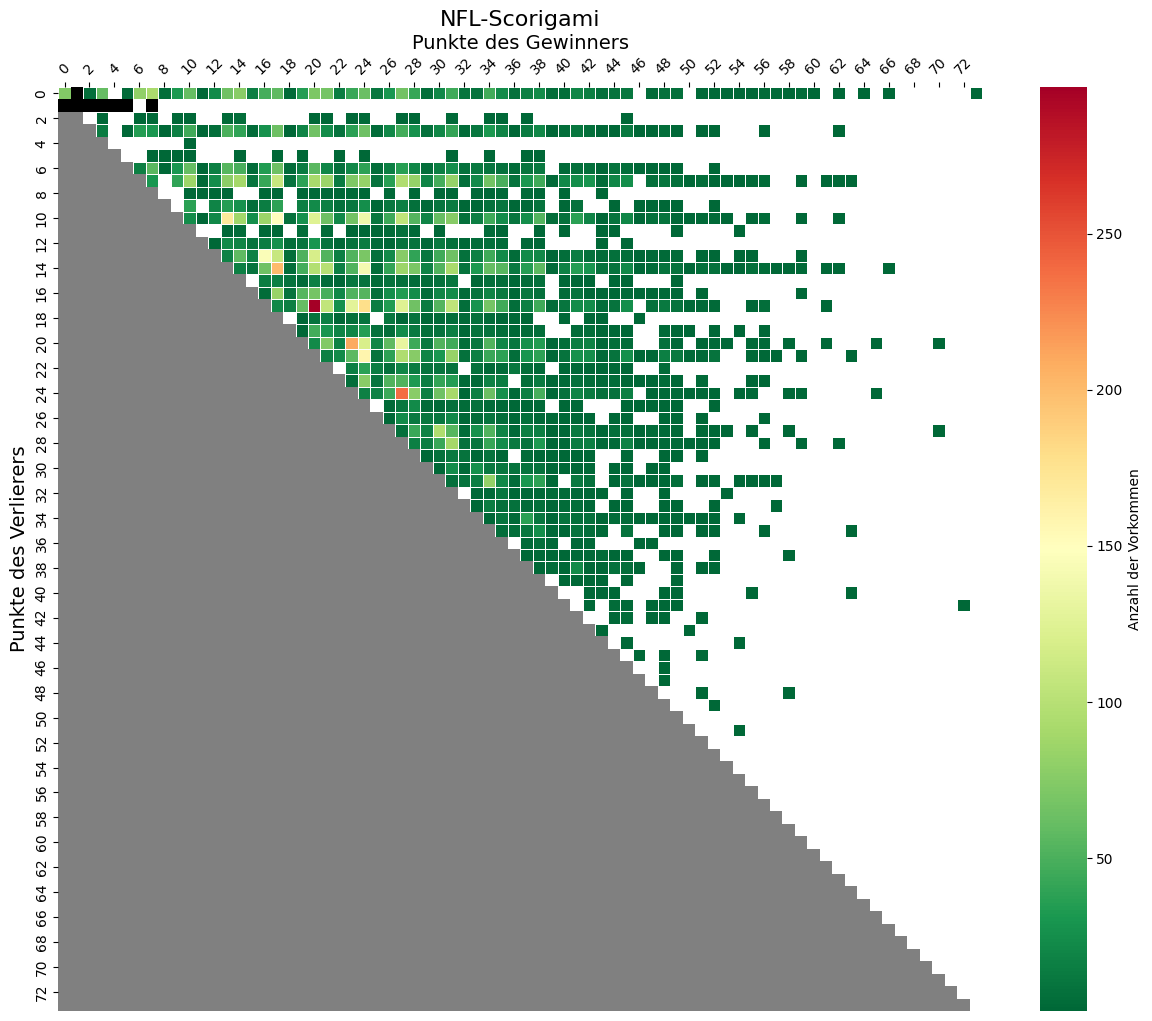

In [213]:
# DataFrame erstellen
games_df = pd.read_csv("data/games_cleaned.csv")
score_counts = games_df.groupby(["pts_w", "pts_l"]).size().reset_index(name="count")
max_points = max(score_counts[["pts_w", "pts_l"]].max()) + 1
heatmap_data = pd.DataFrame(0, index=range(max_points), columns=range(max_points))

# Aggregierte Werte in die Heatmap einfügen
for _, row in score_counts.iterrows():
    heatmap_data.at[int(row["pts_l"]), int(row["pts_w"])] = int(row["count"])  # Gewinner & Verlierer vertauscht

# Maske für leere Werte erstellen
mask_missing = heatmap_data == 0  # Maskiere alle Felder mit Wert 0

# Maske für regulär unmögliche Ergebnisse (Verlierer kann nicht mehr Punkte als Gewinner haben)
mask_impossible = np.zeros_like(heatmap_data, dtype=bool)
for loser_points in range(max_points):
    for winner_points in range(max_points):
        if winner_points < loser_points:  # Unmögliches Ergebnis
            mask_impossible[loser_points, winner_points] = True

# Maske für spezielle NFL-Regel-unmögliche Kombinationen
mask_extra_impossible = np.zeros_like(heatmap_data, dtype=bool)
extra_black_combinations = [(1, 7), (1, 5), (1, 4), (1, 3), (1, 2), (1, 1), (1, 0), (0, 1)]
for loser, winner in extra_black_combinations:
    # If-Statement mit ChatGPT generiert
    if loser < max_points and winner < max_points:
        mask_extra_impossible[loser, winner] = True
        heatmap_data.at[loser, winner] = np.nan  # Sicherstellen, dass sie als unmöglich behandelt werden

# Heatmap erstellen
fig, ax = plt.subplots(figsize=(15, 12))

# Normale Heatmap mit weißen Rändern (für gültige Werte)
sns.heatmap(
    heatmap_data,
    mask=mask_missing,  
    cmap=sns.color_palette("RdYlGn_r", as_cmap=True),  
    linewidths=0.5,  
    square=True, 
    cbar=True,  
    cbar_kws={"label": "Anzahl der Vorkommen"}  
)

sns.heatmap(
    np.where(mask_impossible, 1, np.nan),  
    mask=~mask_impossible, 
    cmap=["#808080"],  
    linewidths=0,  # Kein Rand für diese Felder
    square=True,
    cbar=False  # Keine zusätzliche Farbskala
)

# Dunkelgraue Heatmap für spezielle NFL-Regeln (1-7, 1-5, ...)
sns.heatmap(
    np.where(mask_extra_impossible, 1, np.nan),  # Nur spezielle NFL-unmögliche Ergebnisse anzeigen
    mask=~mask_extra_impossible,  # Umgekehrte Maske
    cmap=["#000000"],  # Dunkelgrau für NFL-Regeln
    linewidths=0,  # KEIN RAND FÜR DIESE FELDER
    square=True,
    cbar=False  # Keine zusätzliche Farbskala
)

# Y-Achse nach oben verschieben
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

# Achsentitel und Layout anpassen
plt.title("NFL-Scorigami", fontsize=16)
plt.xlabel("Punkte des Gewinners", fontsize=14)  # Jetzt Gewinner
plt.ylabel("Punkte des Verlierers", fontsize=14)  # Jetzt Verlierer
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)

# Heatmap anzeigen
plt.show()

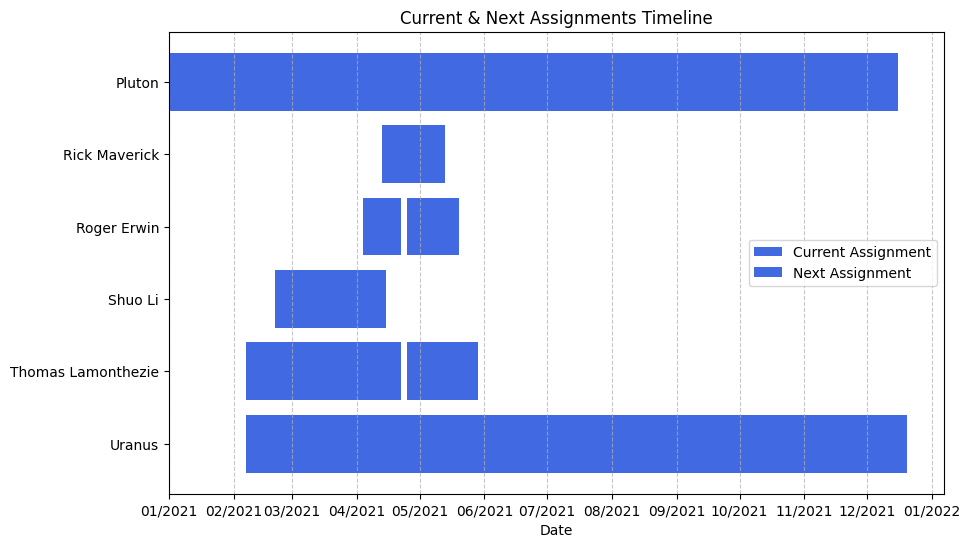

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

# Beispiel-Daten
tasks = [
    ("Uranus", "2021-02-07", "2021-12-20", "2021-05-02", "2021-09-30"),
    ("Thomas Lamonthezie", "2021-02-07", "2021-04-22", "2021-04-25", "2021-05-29"),
    ("Shuo Li", "2021-02-21", "2021-04-15", None, None),
    ("Roger Erwin", "2021-04-04", "2021-04-22", "2021-04-25", "2021-05-20"),
    ("Rick Maverick", "2021-04-13", "2021-05-13", None, None),
    ("Pluton", "2021-01-01", "2021-12-16", None, None)
]

fig, ax = plt.subplots(figsize=(10, 6))

# Farben
current_color = "royalblue"
next_color = "royalblue"

# Achsen-Einstellungen
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))

# Daten visualisieren
for i, (task, start1, end1, start2, end2) in enumerate(tasks):
    start1 = datetime.datetime.strptime(start1, "%Y-%m-%d")
    end1 = datetime.datetime.strptime(end1, "%Y-%m-%d")
    ax.barh(task, (end1 - start1).days, left=start1, color=current_color, label="Current Assignment" if i == 0 else "")

    if start2 and end2:
        start2 = datetime.datetime.strptime(start2, "%Y-%m-%d")
        end2 = datetime.datetime.strptime(end2, "%Y-%m-%d")
        ax.barh(task, (end2 - start2).days, left=start2, color=next_color, label="Next Assignment" if i == 0 else "")

# Legende & Layout-Anpassungen
ax.legend()
plt.xlabel("Date")
plt.title("Current & Next Assignments Timeline")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()
